In [31]:
import simpy
import random
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import math

%matplotlib inline

In [6]:
CARRILES_NORMALESS = 2
CARRILES_PESADOS = 1
TIEMPO_LLEGADA = 3

TIEMPO_EJECUCION = 30 * 24 * 60 # DIAS * HORAS * MINUTOS



In [41]:
def tiempo_revision():
    return int(np.random.normal(20,10,1)[0])

def seleccion_vehiculo():
    return np.random.choice([1,2], p=[0.15,0.85])#1=pesado   y 2=normal

def pasan_revision():
    return np.random.choice([1,2], p=[0.6,0.4])#1=si   y 2=no


Total pesados revisados (carril pesados): 630
Total normales revisados (carril normales): 1228
Total revisados: 1858
Total rechasados: 1213


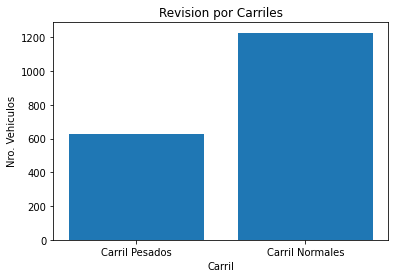

------------------------------------------
Total revisados el dia 0: 52
Total revisados el dia 1: 70
Total revisados el dia 2: 55
Total revisados el dia 3: 59
Total revisados el dia 4: 64
Total revisados el dia 5: 54
Total revisados el dia 6: 66
Total revisados el dia 7: 63
Total revisados el dia 8: 62
Total revisados el dia 9: 63
Total revisados el dia 10: 57
Total revisados el dia 11: 65
Total revisados el dia 12: 61
Total revisados el dia 13: 58
Total revisados el dia 14: 61
Total revisados el dia 15: 55
Total revisados el dia 16: 70
Total revisados el dia 17: 63
Total revisados el dia 18: 55
Total revisados el dia 19: 61
Total revisados el dia 20: 61
Total revisados el dia 21: 68
Total revisados el dia 22: 63
Total revisados el dia 23: 66
Total revisados el dia 24: 58
Total revisados el dia 25: 70
Total revisados el dia 26: 62
Total revisados el dia 27: 72
Total revisados el dia 28: 65
Total revisados el dia 29: 59


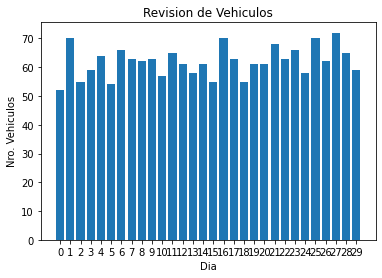

------------------------------------------
Porcentaaje de vehiculos rechazados: 39.498534679257574
Porcentaje de vehiculos revisados de manera directa: 60.501465320742426


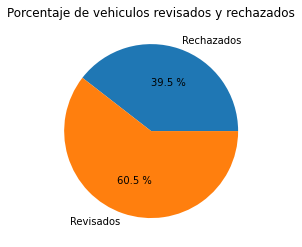

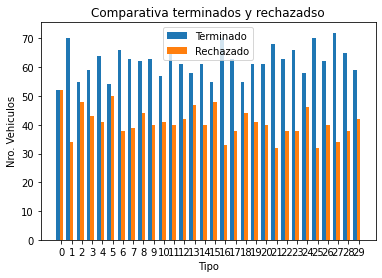

------------------------------------------
Minutos de trabajo realizado en el dia 0: 4203
Minutos de trabajo realizado en el dia 1: 4366
Minutos de trabajo realizado en el dia 2: 4256
Minutos de trabajo realizado en el dia 3: 4361
Minutos de trabajo realizado en el dia 4: 4306
Minutos de trabajo realizado en el dia 5: 4368
Minutos de trabajo realizado en el dia 6: 4307
Minutos de trabajo realizado en el dia 7: 4311
Minutos de trabajo realizado en el dia 8: 4349
Minutos de trabajo realizado en el dia 9: 4338
Minutos de trabajo realizado en el dia 10: 4302
Minutos de trabajo realizado en el dia 11: 4263
Minutos de trabajo realizado en el dia 12: 4364
Minutos de trabajo realizado en el dia 13: 4292
Minutos de trabajo realizado en el dia 14: 4337
Minutos de trabajo realizado en el dia 15: 4310
Minutos de trabajo realizado en el dia 16: 4374
Minutos de trabajo realizado en el dia 17: 4246
Minutos de trabajo realizado en el dia 18: 4308
Minutos de trabajo realizado en el dia 19: 4361
Minutos

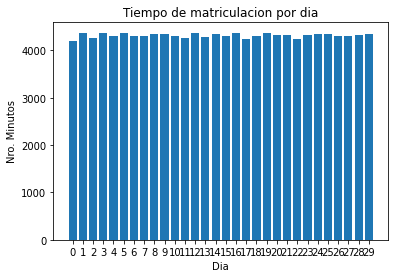

In [88]:
vehiculos_rechasados = {} # hora que regresa , tipo de vehiculo


cantidad = {}


vehiculos_dia = {}


minutos_dia = {}


terminados_dia = {}
rechazados_dia = {}

class negocio(object):
    def __init__(self, env, num_carriles):
        self.env = env
        self.carriles = simpy.Resource(env, num_carriles)

    def revision(self, tiempo_revision):
        yield self.env.timeout(tiempo_revision)

        


def llegada_vehiculo(env,negocio,tipo):
    with negocio.carriles.request() as carril:
        yield carril

        tiempo_inicio_proceso = env.now

        #tiempo de llegada
        yield env.timeout(random.randint(3,5))
        #tiempo cuando saca el turno
        yield env.timeout(random.randint(1,3))
        #tiempo cuando paga la matricula
        yield env.timeout(random.randint(5,10))

        #hacer un if para ver si consiguio o no terminar el proceso para darles sello
        t = tiempo_revision()
        while t < 0:
            t = tiempo_revision()
        yield env.process(negocio.revision(t))

        #para saber si pasa o no la revision
        res = pasan_revision()
        if(res==1):# si paso la revision
            yield env.timeout(random.randint(1,2)) # sello
            if(tipo in cantidad):
                cantidad[tipo] += 1
            else:
                cantidad[tipo] = 1
            
            #cantidad de revisiones por dia
            tiempo_dia = env.now
            dia = math.trunc(tiempo_dia/1440)
            if(dia in vehiculos_dia):
                vehiculos_dia[dia] += 1
            else:
                vehiculos_dia[dia] = 1
                
            if(dia in terminados_dia):
                terminados_dia[dia] += 1
            else:
                terminados_dia[dia] = 1

        else:
            tiempo_volver = env.now + 2880
            vehiculos_rechasados[tiempo_volver] = tipo

            tiempo_dia = env.now
            dia = math.trunc(tiempo_dia/1440)
            if(dia in rechazados_dia):
                rechazados_dia[dia] += 1
            else:
                rechazados_dia[dia] = 1
        #si cuando un vehiculo es rechazado y no cuenta el tiempo de salida, meter esto dentro de un if
        #tiempo de salida
        yield env.timeout(random.randint(5,10))

        tiempo_fin_proceso = env.now

        tiempo_dia = env.now
        dia = math.trunc(tiempo_dia/1440)
        if(dia in minutos_dia):
            minutos_dia[dia] += tiempo_fin_proceso - tiempo_inicio_proceso
        else:
            minutos_dia[dia] = tiempo_fin_proceso - tiempo_inicio_proceso



def ejecutar_simulacion(env, num_carriles_normal, num_carriles_pesados):
    carriles_normales = negocio(env, num_carriles_normal)
    carril_pesado = negocio(env, num_carriles_pesados)

    #generacion de llegada de carros
    tie_llegada = env.now
    while True:
        k = env.now
        if k in vehiculos_rechasados:
            if vehiculos_rechasados[k]==1:
                env.process(llegada_vehiculo(env,carril_pesado,vehiculos_rechasados[k]))
            else:
                env.process(llegada_vehiculo(env,carriles_normales,vehiculos_rechasados[k]))


        if(tie_llegada==k):
            tipo = seleccion_vehiculo()
            if(tipo==1):
                env.process(llegada_vehiculo(env,carril_pesado,tipo))
            else:
                env.process(llegada_vehiculo(env,carriles_normales,tipo))
            tie_llegada=k+3
        
        yield env.timeout(1)


random.seed(77)

env = simpy.Environment()
env.process(ejecutar_simulacion(env,CARRILES_NORMALESS,CARRILES_PESADOS))

env.run(until = TIEMPO_EJECUCION)

print('Total pesados revisados (carril pesados): %s' % cantidad[1])
print('Total normales revisados (carril normales): %s' % cantidad[2])
print('Total revisados: %s' % (cantidad[1]+cantidad[2]))
print('Total rechasados: %s' % len(vehiculos_rechasados))

valoresCarriles = [cantidad[1],cantidad[2]]
etiquetasCarriles = ['Carril Pesados', 'Carril Normales']
plt.bar(range(len(etiquetasCarriles)), valoresCarriles, align="center", tick_label=etiquetasCarriles)
plt.title("Revision por Carriles")
plt.xlabel("Carril")
plt.ylabel("Nro. Vehiculos")
plt.show()


print('------------------------------------------')

for x in vehiculos_dia:
    print('Total revisados el dia %s: %s' % (x,vehiculos_dia[x]))




etiquetas = list(vehiculos_dia.keys())
valores = list(vehiculos_dia.values())
plt.bar(range(len(vehiculos_dia)), valores, align="center", tick_label=etiquetas)
plt.title("Revision de Vehiculos")
plt.xlabel("Dia")
plt.ylabel("Nro. Vehiculos")
plt.show()

print('------------------------------------------')

porcentaje = (len(vehiculos_rechasados)*100)/(cantidad[1]+cantidad[2]+len(vehiculos_rechasados))
print('Porcentaaje de vehiculos rechazados: ' + str(porcentaje))
print('Porcentaje de vehiculos revisados de manera directa: ' + str(100-porcentaje))

valores_pie = [porcentaje, (100-porcentaje)]
nombres_pie = ['Rechazados','Revisados']
plt.pie(valores_pie,labels=nombres_pie, autopct='%0.1f %%')
plt.title('Porcentaje de vehiculos revisados y rechazados')
plt.show()


indice = np.arange(len(terminados_dia))
plt.bar(indice, list(terminados_dia.values()), width=0.35, tick_label=list(terminados_dia.keys()),label='Terminado')
plt.bar(indice+0.35, list(rechazados_dia.values()), width=0.35, tick_label=list(rechazados_dia.keys()),label='Rechazado')
plt.title("Comparativa terminados y rechazadso")
plt.xlabel("Tipo")
plt.ylabel("Nro. Vehiculos")
plt.legend(loc='best')
plt.show()


print('------------------------------------------')

for x in minutos_dia:
    print('Minutos de trabajo realizado en el dia %s: %s' % (x,minutos_dia[x]))




etiquetasTiempo = list(minutos_dia.keys())
valoresTiempo = list(minutos_dia.values())
plt.bar(range(len(minutos_dia)), valoresTiempo, align="center", tick_label=etiquetasTiempo)
plt.title("Tiempo de matriculacion por dia")
plt.xlabel("Dia")
plt.ylabel("Nro. Minutos")
plt.show()